In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn

import os

from util import (
    get_torch_size_string
)
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    DiffusionUNet,
)

from dataset import mnist

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.1.1].


In [2]:
device = 'cuda'
print ("device:[%s]"%(device))

device:[cuda]


```Python
betas = get_named_beta_schedule(
    schedule_name           = schedule_name,
    num_diffusion_timesteps = T,
    scale_betas             = 1.0,
).astype(np_type) # [1,000]
alphas                    = 1.0 - betas 
alphas_bar                = np.cumprod(alphas, axis=0) #  cummulative product
alphas_bar_prev           = np.append(1.0,alphas_bar[:-1])
sqrt_recip_alphas         = np.sqrt(1.0/alphas)
sqrt_alphas_bar           = np.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = np.sqrt(1.0-alphas_bar)
posterior_variance        = betas*(1.0-alphas_bar_prev)/(1.0-alphas_bar)
posterior_variance        = posterior_variance.astype(np_type)
```

[ 0] key:[schedule_name]
[ 1] key:[T]
[ 2] key:[timesteps]
[ 3] key:[betas]
[ 4] key:[alphas]
[ 5] key:[alphas_bar]
[ 6] key:[alphas_bar_prev]
[ 7] key:[sqrt_recip_alphas]
[ 8] key:[sqrt_alphas_bar]
[ 9] key:[sqrt_one_minus_alphas_bar]
[10] key:[posterior_variance]


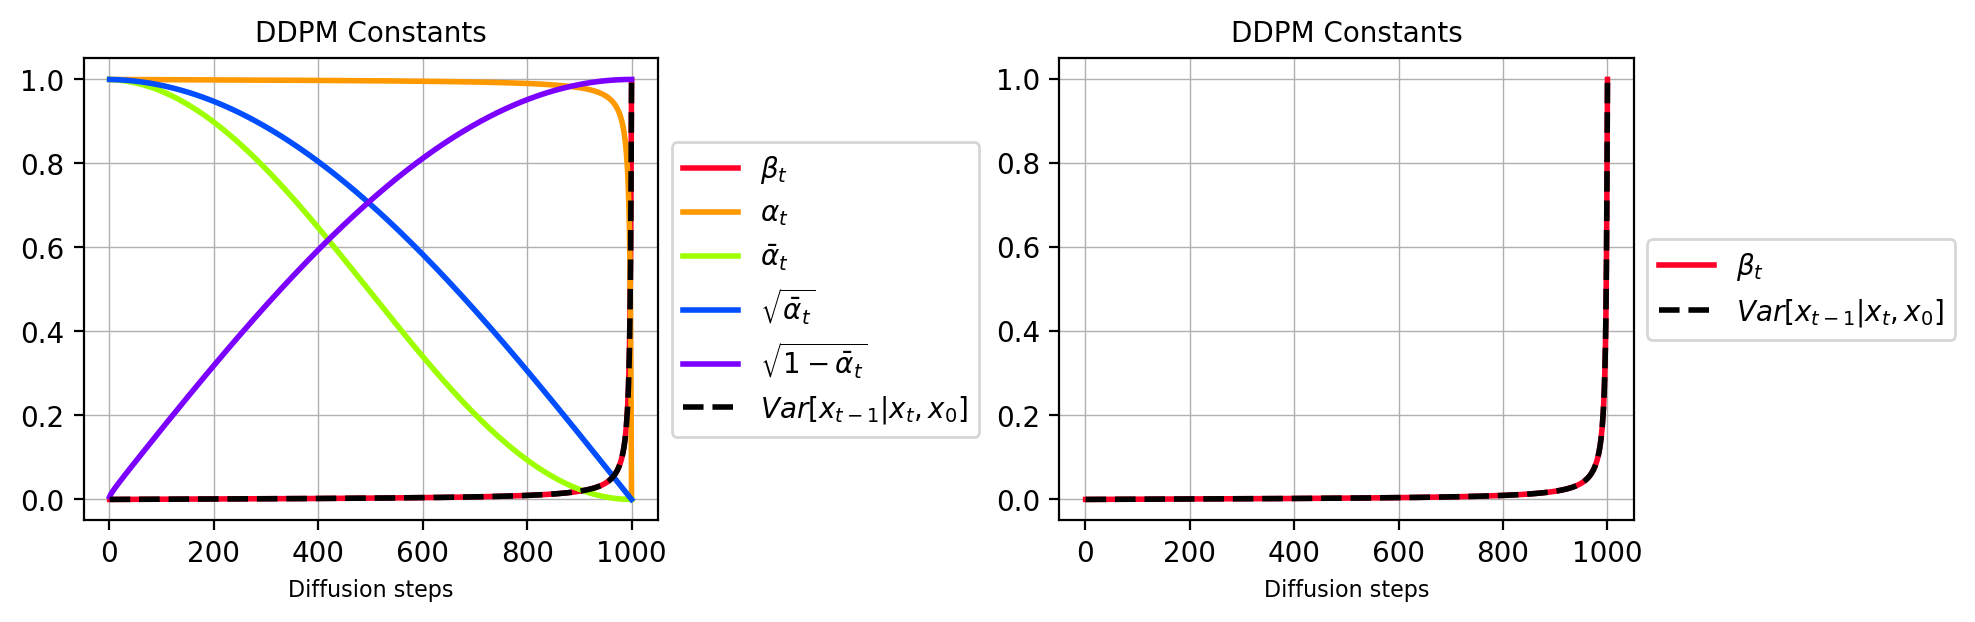

In [5]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
for k_idx,key in enumerate(dc.keys()):
    print ("[%2d] key:[%s]"%(k_idx,key))
plot_ddpm_constants(dc)

In [6]:
unet = DiffusionUNet(
    name             = 'unet',
    dims             = 1,
    n_in_channels    = 3,
    n_model_channels = 64,
    n_emb_dim        = 128,
    n_enc_blocks     = 2, # number of encoder blocks
    n_dec_blocks     = 2, # number of decoder blocks
    n_groups         = 16, # group norm paramter
    use_resblock     = True,
    use_attention    = True,
    skip_connection  = True, # additional skip connection
    device           = device,
)
# Inputs, timesteps:[B] and x:[B x C x L]
batch_size = 2
x = th.randn(batch_size,3,200).to(device) # [B x C x L]
timesteps = th.linspace(1,dc['T'],batch_size).to(th.int64).to(device) # [B]
out,intermediate_output_dict = unet(x,timesteps)
print ("Input: x:[%s] timesteps:[%s]"%(
    get_torch_size_string(x),get_torch_size_string(timesteps)
))
print ("Output: out:[%s]"%(get_torch_size_string(out)))
# Print intermediate layers
for k_idx,key in enumerate(intermediate_output_dict.keys()):
    z = intermediate_output_dict[key]
    print ("[%2d] key:[%12s] shape:[%12s]"%(k_idx,key,get_torch_size_string(z)))

Input: x:[2x3x200] timesteps:[2]
Output: out:[2x3x200]
[ 0] key:[           x] shape:[     2x3x200]
[ 1] key:[    x_lifted] shape:[    2x64x200]
[ 2] key:[h_enc_res_00] shape:[    2x64x200]
[ 3] key:[h_enc_att_01] shape:[    2x64x200]
[ 4] key:[h_enc_res_02] shape:[    2x64x200]
[ 5] key:[h_enc_att_03] shape:[    2x64x200]
[ 6] key:[ h_enc_stack] shape:[   2x128x200]
[ 7] key:[h_dec_res_00] shape:[    2x64x200]
[ 8] key:[h_dec_att_01] shape:[    2x64x200]
[ 9] key:[h_dec_res_02] shape:[    2x64x200]
[10] key:[h_dec_att_03] shape:[    2x64x200]
[11] key:[         out] shape:[     2x3x200]
